### Import

In [2]:
import numpy as np
import sympy as sp

import matplotlib
import matplotlib.pyplot as plt

from sympy import Matrix, init_printing

import qiskit
from qiskit import *

# Representing Data
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

# Monitor Job on Real Machine
from qiskit.tools.monitor import job_monitor

from functools import reduce # perform sucessive tensor product

# Calculating cost
from sklearn.metrics import mean_squared_error

# Generating random unitary matrix
from scipy.stats import unitary_group

# Measure run time
import time

# Almost Equal
from numpy.testing import assert_almost_equal as aae

Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc' line #2.
Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc' line #3.


### Problem

Implement a circuit which returns $|00\rangle$ and $|11 \rangle$ with equal probability.

Requirements :

- Circuit should consist only of CNOTs, RXs and RYs. 

- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 

- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 

- Simulations must be done with sampling - i.e. limited number of measurements per iteration and noise. 

- Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:

- How to make sure you produce state $|00\rangle +|11 \rangle$ and not $|00\rangle - |11\rangle$ ?


### Plan

    1. Create a quantum circuit with Hamadamard and CX

    2. Decompose Hadamard into R_X and R_Y using gate decomposition

    3. Draw Neural Network graph

    4. Create data to train/test

    5. Initialized weights

    6. Implement Forward Propagation

    7. Define Cost function

    8. Implement Backpropagation

    9. Implement Gradient Descent to updates the weights in each layers
    
    10. Check that each layer is implemented correctly
    
    11. Train Model
    
    12. Evaluate Model
    
    13. Full Optimization Implementation
    
    14. Sampling on Quantum Circuit
    

Optional:

    1. Implement Adam Optimization
    2. Implement General Neural Network
    3. Implement Forward Prop with simulation
    4. Bonus question

### Helpful Linear Algebra Resources

In [53]:
# Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])

# Eigenvectors of Pauli Matrices
zero = np.array([[1], [0]]) # Z plus basis state
one = np.array([[0], [1]]) # Z plus basis state

plus = np.array([[1], [1]])/np.sqrt(2) # X plus basis state
minus = np.array([[1], [-1]])/np.sqrt(2) # X minus basis state

up = np.array([[1], [1j]])/np.sqrt(2) # Y plus basis state
down = np.array([[1], [-1j]])/np.sqrt(2) # Y plus basis state

# Bell States
B00 = np.array([[1], [0], [0], [1]])/np.sqrt(2) # Bell of 00
B01 = np.array([[1], [0], [0], [-1]])/np.sqrt(2) # Bell of 01
B10 = np.array([[0], [1], [1], [0]])/np.sqrt(2) # Bell of 10
B11 = np.array([[0], [-1], [1], [0]])/np.sqrt(2) # Bell of 11

# Rn Matrix Function
Rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
Rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

# Tensor Product of 2+ matrices/ vectors
tensor = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

###### View Matrix

In [6]:
def view(mat):
    display(Matrix(mat))

### Get Unitary/StateVector Function

In [7]:
# This function return the statevector or the unitary of an inputted circuit

def get(circ, types = 'unitary'):
    if types == 'statevector':
        backend = BasicAer.get_backend('statevector_simulator')
        out = execute(circ, backend).result().get_statevector()
    else: 
        backend = BasicAer.get_backend('unitary_simulator')
        out = execute(circ, backend).result().get_unitary()
        
    return display(Matrix(np.round(out, 10)))

### Draw Neural Networks

In [8]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                
                
# Draw neural network for this problem
def draw_nn():
    fig = plt.figure(figsize=(8, 8))

    fig.text(0.15, 0.76, 'Input Layer', fontsize = 12)
    fig.text(0.75, 0.76, 'Output Layer', fontsize = 12)

    # Input Layer
    fig.text(0.177, 0.65, 'x_0', fontsize = 16)
    fig.text(0.177, 0.35, 'x_1', fontsize = 16)
    
    # Output Layer
    fig.text(0.795, 0.65, 'y_0', fontsize = 16)
    fig.text(0.795, 0.35, 'y_1', fontsize = 16)

    ax = fig.gca()
    ax.axis('off')
    draw_neural_net(ax, .1, .9, .1, .9, [2, 2])


### Step 1: Build Bell Circuit

Create a quantum circuit with Hadamard and CX

Typically, a circuit to create the $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ looks like this

Matrix([
[0.7071067812,  0.7071067812,            0,             0],
[           0,             0, 0.7071067812, -0.7071067812],
[           0,             0, 0.7071067812,  0.7071067812],
[0.7071067812, -0.7071067812,            0,             0]])

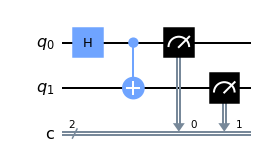

In [9]:
# Quantum Circuit with Hadamard and CX
circ0 = QuantumCircuit(2, 2)
circ0.h(0)
circ0.cx(0, 1)

get(circ0)

circ0.measure([0, 1], [0, 1])

circ0.draw('mpl')

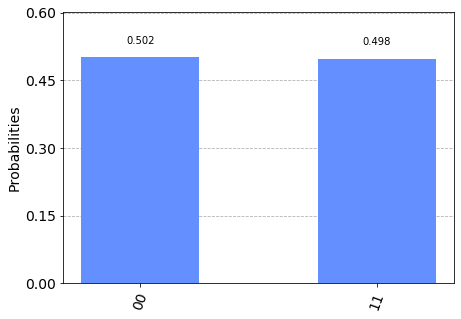

In [10]:
simulator = Aer.get_backend('qasm_simulator')

# For Mathematical Representation
results = execute(circ0, simulator).result()

# Count Results
counts = results.get_counts(circ0)

# Plot Histogram
plot_histogram(counts)

The outputs of the four CBS for this circuit are the following

Let matrix B represents the unitary of the circuit

$$B |00\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

$$B |01\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)$$

$$B |10\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)$$

$$B |11\rangle = \frac{1}{\sqrt{2}} (-|01\rangle + |10\rangle)$$

### Step 2: Hadamard Decomposition

Decompose Hadamard into $R_X(\phi)$ and $R_Y(\theta)$ using gate decomposition

#### Hadamard

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1\\ 1 & -1  \end{bmatrix}$$

#### X-axis Rotation

$$R_X( \theta ) = \begin{bmatrix} \cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\ -i \sin \frac{\theta}{2} & \cos \frac{\theta}{2}  \end{bmatrix}$$

#### Y-axis Rotation

$$R_Y( \theta ) = \begin{bmatrix} \cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2}  \end{bmatrix}$$

The Hadamard decomposition is as followed:

$$H = R_y(-\frac{\pi}{2})R_x(\pi)$$

Subsequently, the new circuit will looks like this

```python

# Implement a R_y, R_x circuit. Notice that the order is flipped
circ = QuantumCircuit(2)
circ.rx(np.pi, 0)
circ.ry(-np.pi/2, 0)
circ.cx(0, 1)

circ.draw('mpl')

```

The outputs of the four CBS for this circuit are the following

Let matrix M represents the unitary of the circuit

$$M |00\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$$

$$M |01\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)$$

$$M |10\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)$$

$$M |11\rangle = \frac{1}{\sqrt{2}} (-|01\rangle + |10\rangle)$$

This is the same as the normal Bell states circuit

### Step 3: Draw Neural Network

The neural network for this aims to mimic the $R_y(-\frac{\pi}{2})R_x(\pi)$ matrix complex

When plugging in the correct value, the $-i$ factors on the $R_x(\phi)$ eventually dissapear as a global phase. 

Because of this, we can frame the $R_x(\phi)$ in a simpler form

$$R_y(\theta)R_x(\phi)(X) = \begin{bmatrix} \cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2}  \end{bmatrix} \begin{bmatrix} \cos \frac{\phi}{2} & \sin \frac{\phi}{2} \\ \sin \frac{\phi}{2} & \cos \frac{\phi}{2}  \end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

The middle two matrices can be reduced into sum and difference formula

$$R_y(\theta)R_x(\phi)(X) = \begin{bmatrix} \cos\frac{\phi + \theta}{2} & \sin\frac{\phi - \theta}{2} \\ \sin\frac{\phi + \theta}{2} & \cos\frac{\phi - \theta}{2}\end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

This neural network has one layers, each layers with two nodes, and each nodes with two weights. We can set the weight matrix $W$ as follow:

$$W = \begin{bmatrix} \cos\frac{\phi + \theta}{2} & \sin\frac{\phi - \theta}{2} \\ \sin\frac{\phi + \theta}{2} & \cos\frac{\phi - \theta}{2}\end{bmatrix} = \begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}$$

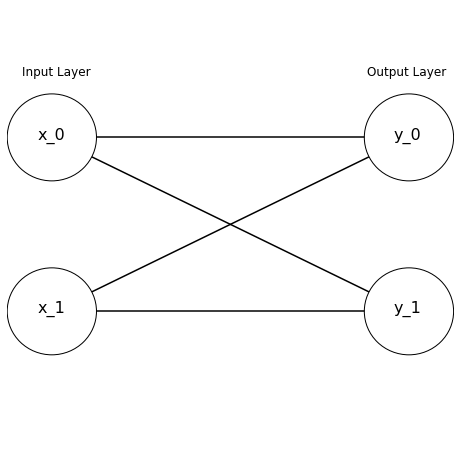

In [11]:
draw_nn()

###### Each nodes in the hidden layer and the output layer contains two weights

The square bracket index represents the layer the node is in.

The curly bracket index represents the position of the node in its respective layer.

###### Output Layer

$$y_0 = W^{[1]\{0\}} \cdot X$$

Where $W^{[1]\{0\}} = \begin{pmatrix} \alpha \\ \beta \end{pmatrix}$, $\alpha$ and $\beta$ are parameters

From this, we can see that the output equals

$$ y_0 = \alpha x_0 + \beta x_1 $$

Also,

$$y_1 = \gamma x_0 + \delta x_1$$

### Step 4: Create data

There are two approachs to doing this: 

1. Create a small number of training examples so the algorithm intentionally overfits the data ( < 10 $(X, y)$ pairs)
2. Create a large number of training examples so the algorithm can be more robust ( > 1000 $(X, y)$ pairs)

Both approachs will be attempted and the better of the two will be chosen

Steps to creating data:

1. Randomize a 2-d real unit vectors, this is $X$ (for this purpose, ignore complex number)
2. Using the known matrix, take the product of the two, this is $y$
3. Repeat the process $n$ times as deemed necessary

#### Single Vector Implementation

```python
M_correct = H

### X-values

# Create a random 2-d real vector
x = np.random.rand(2, 1)

# Normalize v
x /= np.linalg.norm(x)

### Y-values

# Matrix Multiplication
y = np.dot(M_correct, x)
```

#### Multiple Vectors Implementation

In [12]:
def create_data(M_correct, size = 500, train_split = 0.7, seed = 0):
    
    """
    
    Create two matrices of specified length consisting of 2-d vectors representing
    a train and a test examples
    
    Parameters
    ----------
    M_correct: ndarray
        Matrix that transform the input to the correct output
    size: int
        Number of examples (train & test) in the dataset
    train_split: float
        Proportion of the train data to the total dataset
        
    
    Returns
    -------
    X_train: ndarray
        Matrix containing the x-values of all the training examples
    y_train: ndarray
        Matrix containing the y-values of all the training examples
    X_test: ndarray
        Matrix containing the x-values of all the testing examples
    y_test: ndarray
        Matrix containing the y-values of all the testing examples

    """
    
    np.random.seed(seed)
    
    # Manage defaults for 'size'
    if size == 'small':
        size = 10
    elif size == 'large':
        size = 1000
    
    ### X-values
    
    # Create a random matrix of 2-d real vectors as columns
    X = np.random.rand (2, size)
    
    # Normalize v by column axix
    X /= np.linalg.norm(X, axis = 0)
    
    # Check for normalization
    assert np.round(np.sum(np.power(X, 2)), 10) == size, 'X is not normalized'
    
    # Check for correct shape
    assert X.shape == (2, size), 'the shape of X is not correct'
    
    ### Y-values
    
    # Matrix Multiplication
    y = np.dot(M_correct, X)
    
    # Check for unitary
    assert np.round(np.sum(np.dot(M_correct, M_correct.conj().T)), 10) == 2, 'M_correct is not unitary'
    
    # Check for correct shape
    assert y.shape == (2, size), 'the shape of y is not correct'
    
    # Splitting the matrix into its corresponding groups
    
    X_train = X[:, :int(size*train_split)]
    y_train = y[:, :int(size*train_split)]
    
    X_test = X[:, int(size*train_split):]
    y_test = y[:, int(size*train_split):]
    
    return X_train, y_train, X_test, y_test

### Step 5: Initialization
The $W$ matrix will be initialized to all zeros or randomly

In [13]:
def initialize(init_type = 'random', dim = (2, 2), seed = 0):
    
    """
    
    Initialize the W matrix of a specified size to all zeros or randomly
    
    Parameters
    ----------
    init_type: str
        Specify whether W will be initialized to all zeros or randomly
    shape: tuple
        Specify shape of W
    seed: int
        Used for pseudo-randomly generate matrix
    
    Returns
    -------
    W: ndarray
        Initialized W matrix (all zeros or pseudo-random)
        
    """
      
    # Zero Initialization
    if init_type == 'zeros':
        
        W = np.zeros(dim)  
        
    # Random Initialization
    else:
        # Keep the values consistent
        np.random.seed(seed)

        W = np.random.rand(*dim)

    # Check for W shape
    assert W.shape == dim, 'shape of W is not correct'
        
    return W

### Step 6: Forward Propagation

Forward propagation passes the input into the neural network to predict an output value

$$\hat{y} = \underbrace{\begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}}_{W} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix}$$

To run multiple training examples at the same time (stochastic), put the training examples into a matrix a multiply it with the weight matrix. The index of training examples will be represented by the superscript inside the parentheses.

$$W(X) \ = \ W \begin{pmatrix} x_0^{(0)} & x_0^{(1)} ... & \ x_0^{(n)} \\ x_1^{(0)} & x_1^{(1)} ... & \ x_1^{(n)} \end{pmatrix} \ = \ \begin{pmatrix} \hat{y}^{(0)} & \hat{y}^{(1)} & ... & \hat{y}^{(n)}\end{pmatrix}$$

There are two ways of running forward propagation:

1. Simulate the circuit using 'qasm_simulator' 

    - This is less practical because it requires taking the square root of the count probability to get back to the weights.
    
    
2. Calculate the output value using directly using linear algebra

    - Forward prop will be calculated using this method at the moment

In [61]:
def forward_prop(W, X):
    
    """
    
    Perform the forward propagation step
    
    Parameters
    ----------
    W: ndarray
        Matrix of the weights in used
    X: ndarray 
        Matrix of x-values
    
    Returns
    -------
    y_hat: ndarray
        Predicted value to be used for back-prop
        
    """
    
    y_hat = np.dot(W, X)
        
    # Make sure the shape is consistent
    assert X.shape == y_hat.shape, 'Shape is not consistent'
    
    return y_hat

### Step 7: Define Cost Function

Because this is a regression problem, we will calculate the cost using Half Mean Squared Error (MSE), which we will define as

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \underbrace{||y_i - \hat{y}_i||^2}_{L(W)}$$

where $N$ is the number of training examples

In [15]:
def cost(y, y_hat):
    
    """
    
    Compute half mean-squared error cost
    
    Parameters
    ----------
    y: ndarray
        The true y value generated from a preset matrix (see step 4: Create Data)
    y_hat: ndarray
        The predicted y value from a learned set of weights (see step 6: Forward Propagation)
    
    Returns
    -------
    J: float
        Scalar matrix to indicate the overall performance of the current set of weights
    
    """
    
    # N is number of training examples
    N = y.shape[1]
    
    # Compute cost function
    J = 1/(2*N) * np.sum(np.linalg.norm(y - y_hat)**2)
    
    return J

### Step 8: Backpropagation

Expanding the matrices from above (only caring about the subscript, we have)

$$\hat{y} = \begin{bmatrix} \cos\frac{\phi + \theta}{2} & \sin\frac{\phi - \theta}{2} \\ \sin\frac{\phi + \theta}{2} & \cos\frac{\phi - \theta}{2}\end{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} = \underbrace{\begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix}}_{W} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} = \begin{pmatrix} \alpha x_0 + \beta x_1 \\ \gamma x_0 + \delta x_1 \end{pmatrix}$$

To find the local minimum, update the parameters opposite of the direction of steepest descent. Backpropagation calculates derivative of the cost function with respect to each of the weights.

From above

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \underbrace{||y_i - \hat{y}_i||^2}_{L(W)}$$

The cost function can be written as 

$$J(W) = \frac{1}{2N} \sum^{N}_{i=1} \begin{Vmatrix} y_0 - (\alpha x_0 + \beta x_1) \\ y_1 - (\gamma x_0 + \delta x_1) \end{Vmatrix}^2 = \frac{1}{2N} \sum^{N}_{i=1} \overbrace{{\underbrace{[(\alpha x_0 + \beta x_1 - y_0]}_{L_0}}^2 + {\underbrace{[\gamma x_0 + \delta x_1 - y_1]}_{L_1}}^2}^{L(W)}$$

In this case, the loss function $L(W)$ can be expressed as the sum of $L_0$ and $L_1$

$$L(W) = (L_0)^2 + (L_1)^2$$

Taking partial derivative with respect to a general weight ($w$)

$$\frac{\partial}{\partial w}J(W) = \frac{1}{2N} \sum^{N}_{i=1} \frac{\partial}{\partial w} L(W) = \frac{1}{2N} \sum^{N}_{i=1} \frac{\partial}{\partial w} [(L_0)^2 + (L_1)^2]$$ 

A $2$ can be factored out after taking the derivative of $(L_0)^2$ and $(L_1)^2$

$$= \frac{1}{N} \sum^{N}_{i=1} \begin{pmatrix} L_0 \frac{\partial L_0}{\partial w} + L_1 \frac{\partial L_1}{\partial w} \end{pmatrix}$$ 

Put everything together, the cost function derivatives with respect to $\alpha, \beta, \gamma$ and $\delta$ are

###### Alpha

$$\frac{\partial J}{\partial \alpha} = \frac{1}{N} \sum^{N}_{i=1} L_0 x_0$$

###### Beta

$$\frac{\partial J}{\partial \beta} = \frac{1}{N} \sum^{N}_{i=1} L_0 x_1$$

###### Gamma

$$\frac{\partial J}{\partial \gamma} = \frac{1}{N} \sum^{N}_{i=1} L_1 x_0$$

###### Delta

$$\frac{\partial J}{\partial \delta} = \frac{1}{N} \sum^{N}_{i=1} L_1 x_1$$

To implement these four calculations in code with multiple training examples, 

1. Calculate the difference between all the $y$'s and $\hat{y}$'s

$$\text{diff} = \begin{pmatrix} y_0 - (\alpha x_0 + \beta x_1) \\ y_1 - (\gamma x_0 + \delta x_1) \end{pmatrix} = y - \hat{y} = \begin{pmatrix} L_0 \\ L_1 \end{pmatrix}$$

2. Elongate this 'diff' matrix & the $X$ matrix as follow and perform element-wise multiplication

$$\text{elem_prod} = \begin{bmatrix} \begin{pmatrix} L_0 \\ L_0 \end{pmatrix} \\ \begin{pmatrix} L_1 \\ L_1  \end{pmatrix} \end{bmatrix} * \begin{bmatrix} \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} \\ \begin{pmatrix} x_0 \\ x_1 \end{pmatrix} \end{bmatrix} = \begin{pmatrix} L_0 x_0 \\ L_0 x_1 \\ L_1 x_0 \\ L_1 x_1\end{pmatrix}$$

3. Recall that each each $x$ and $L$ contains multiple training examples. 

Take the average of the row of the matrix and unpack it to the appropriate derivative variable. Note that $\frac{\partial J}{\partial w}$ turns into $\partial w$

$$J = \frac{1}{N} \begin{pmatrix} \sum^{N}_{i=1} L_0 x_0 \\ \sum^{N}_{i=1} L_0 x_1 \\ \sum^{N}_{i=1} L_1 x_0 \\ \sum^{N}_{i=1} L_1 x_1\end{pmatrix} = \begin{pmatrix} \partial \alpha \\ \partial \beta \\ \partial \gamma \\ \partial \delta \end{pmatrix}$$

4. Finally reshape the weights into a square matrix for the gradient descent step

$$\begin{pmatrix} \partial \alpha \\ \partial \beta \\ \partial \gamma \\ \partial \delta \end{pmatrix} \longrightarrow \begin{bmatrix} \partial \alpha & \partial \beta \\ \partial \gamma & \partial \delta \end{bmatrix}$$

In [16]:
def back_prop(y, y_hat, X):
        
    """
    Calculate derivatives of the cost function (see step 7: Define Cost Function)
    
    Parameters
    ----------
    y: ndarray
        The true y value generated from a preset matrix (see step 4: Create Data)
    y_hat: ndarray
        The predicted y value from a learned set of weights (see step 6: Forward Propagation)
    X: ndarray
        The X value used to generate the 'y' value
        
    Returns
    -------
    dJ: ndarray
        Matrix of partial derivatives with respect to each of the weights
        
    """

    # Extract number of examples
    N = y_hat.shape[1]

    # Reshape X
    X = np.reshape(X, (2, N))

    # Calculate the y - y_hat
    diff = y - y_hat

    # Elongate the diff array with repeating elements
    diff = np.repeat(diff, 2, axis = 0)

    # Reshape
    diff = np.reshape(diff, (4, N))

    # Elongate the x array with alternating elements
    X = np.vstack((X, X))

    # Check to see if both array has the same shape

    assert X.shape == diff.shape, 'Shape is not consistent'

    # Element-wise multiplication between the diff matrix and the x matrix
    elem_prod = diff * X

    # Average the row of the matrix
    dJ = (1/N) * np.sum(elem_prod, axis = 1)

    # Reshape

    dJ = np.reshape(dJ, (4, 1))

    # Check J shape
    assert dJ.shape == (4,1), 'Shape is not correct'

    # Reshape J into a matrix
    dJ = dJ.reshape(2, 2)

    assert dJ.shape == (2, 2), 'Shape is not square'

    return dJ

### Step 9: Gradient Descent (GD)

The general weight update with learning rate $\rho$ is as follow

$$w := w - \rho \frac{\partial J}{\partial w}$$

$\rho$ is defaulted as 0.001. However, once the implementation is sucessful, $\rho$ can be varied.

In [17]:
def gradient_descent(weights, grad, learning_rate = 0.001):
    
    """
    
    Update the weights using gradients calculated from step 8: Backpropagation
    
    Parameters
    ----------
    weights: ndarray
        Matrix of weights used for training
    grad: ndarray
        Matrix of gradients calculated from step 8: Backpropagation
    learning_rate: float
        Determines the speed step size of the weights update
        
    Returns
    -------
    new_weights: ndarray
        Matrix of weights after updated
        
    """
    
    new_weights = weights - learning_rate * grad
    
    assert weights.shape == new_weights.shape
    
    assert new_weights.shape == (2, 2)
    
    return new_weights

### Step 10: Check for Correct Implementation

Checklist:

    1. Create train/test data
    2. Initialization
    3. Forward Propagation
    4. Define Cost Function
    5. Back Propagation
    6. Gradient Descent

##### 1. Create train/test data

Check the following:

1. Correct shape for both train and test set from 'size' and 'train_split'
2. The y matrix is the output of the X matrix with the M_correct

Run the code below to check

```python
for i in range(10_000):
    
    # Size of dataset
    n = np.random.randint(1, 10_000)
    
    # Train split
    split = np.random.uniform()
    
    # Random unitary matrix
    M = unitary_group.rvs(2)
        
    X_train, y_train, X_test, y_test = create_data(M, size = n, train_split = split)
    
    # Same shape for training pairs
    assert X_train.shape == y_train.shape
    
    # Same shape for testing pairs
    assert X_test.shape == y_test.shape
    
    # Correct no. of examples from 'size' and 'train_split'
    assert X_train.shape[1] == int(n * split)
    
    # Everything adds up to 'size'
    assert X_train.shape[1] + X_test.shape[1] == n
    
    # Check the output y is correct
    assert np.round(np.sum(np.dot(M, X_train) - y_train), 10) == 0
    
    assert np.round(np.sum(np.dot(M, X_test) - y_test), 10) == 0
    
print('Everything is good')

```

###### 2. Initialization

The code for this is simple enough to just be inspect by eye

###### 3. Forward Propagation

Checking by running through random examples

Run the code below to check

```python 
for i in range(10_000):

    # Random weight matrix
    W = np.random.rand(2, 2)

    # Random X matrix
    n = np.random.randint(1, 10_000)
    X = np.random.rand(2, n)

    # Run function
    forward_prop(W, X, path = None)

print('Everything is good')
```

###### 4. Define Cost Function

This can be checked by comparing it to the 'mean_squared_error' within scikit learn

Run the code below to check

```python
for i in range(10_000):
    
    np.random.seed(i)

    n = np.random.randint(1, 10_000)
    y = np.random.rand(2, n)
    y_hat = np.random.rand(2, n)

    assert np.round(mean_squared_error(y, y_hat) - cost(y, y_hat), 15) == 0
     
print('Everything is good')
```

After 10_000 random examples, it can be seen that the two function is equivalent, when the first dimension of the matrix is 2. However, when this dimension is not 2, the difference is drastic. In the end, the cost(y, y_hat) function will be used because it is significantly faster.

###### 5. Back Propagation

Check the following:

1. Manually check if all the steps is implemented correctly

2. Check that back_prop(y, y, X) = 0, 0, 0, 0

3. Perform gradient checking

1. This is the first step. The code preceding the assert statement is a step-by-step break down (non-vectorized) implementation of the back-prop module. It is manually check for small matrix size. The result is the same for the first 100_000 examples

```python
for i in range(100_000):
    
    np.random.seed(i)
    
    n = np.random.randint(1, 10_000)

    X = np.random.rand(2, n)

    x_0 = X[0]
    x_0 = np.reshape(x_0, (1, n))

    x_1 = X[1]
    x_1 = np.reshape(x_1, (1, n))

    np.random.seed(i+1)

    y = np.random.rand(2, n)

    np.random.seed(i+2)

    y_hat = np.random.rand(2, n)

    diff = y - y_hat

    L_0 = diff[0]
    L_0 = np.reshape(L_0, (1, n))

    L_1 = diff[1]
    L_1 = np.reshape(L_1, (1, n))

    # Alpha
    d_alpha = (1/n) * np.sum(L_0 * x_0)

    # Beta
    d_beta = (1/n) * np.sum(L_0 * x_1)

    # Gamma
    d_gamma = (1/n) * np.sum(L_1 * x_0)

    # Delta
    d_delta = (1/n) * np.sum(L_1 * x_1)

    dJ = np.array([[d_alpha, d_beta], [d_gamma, d_delta]])
    
    assert np.sum(dJ - back_prop(y, y_hat, X)) == 0, 'not equal'
```

2. Check that back_prop(y, y, X) = 0, 0, 0, 0

This is correct for 10_000 random examples

```python
for i in range(10_000):
    n = np.random.randint(1, 10_000)
    X_train, y_train, X_test, y_test = create_data(H, size = n, train_split = 1, seed = i)

    assert np.all(back_prop(y_train, y_train, X_train) == np.zeros((2, 2)))
```

3. Grad Check

Run code below to compare 'back_prop' function and numerically calculated gradient

The numerical derivative will be calculated using a two-sided derivative

$$ \frac{\partial J}{\partial w} = \lim_{\varepsilon \to 0} \frac{J(w + \varepsilon) - J(w - \varepsilon)}{2 \varepsilon}$$

```python
for i in range(10_000):
    n = np.random.randint(1, 10_000)

    X_train, y_train, _ , _   = create_data(H, size = n, train_split=1, seed = i)

    W = initialize('random', dim = (2, 2), seed = i)

    y_hat = forward_prop(W, X_train)

    grad = back_prop(y_train, y_hat, X_train)

    epsilon = 1e-7

    # Create epsilon Matrix
    ep_alpha = np.array([[epsilon, 0], [0, 0]])

    ep_beta = np.array([[0, epsilon], [0, 0]])

    ep_gamma = np.array([[0, 0], [epsilon, 0]])

    ep_delta = np.array([[0, 0], [0, epsilon]])

    # Alpha

    # + epsilon on the alpha term
    alpha_plus = W + ep_alpha
    alpha_minus = W - ep_alpha

    # Forward Prop
    numerator = cost(y_train, forward_prop(alpha_plus, X_train)) - cost(y_train, forward_prop(alpha_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_alpha_appox = np.mean(numerator / denominator) * 2

    # Beta

    # + epsilon on the beta term
    beta_plus = W + ep_beta
    beta_minus = W - ep_beta

    # Forward Prop
    numerator = cost(y_train, forward_prop(beta_plus, X_train)) - cost(y_train, forward_prop(beta_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_beta_appox = np.mean(numerator / denominator) * 2

    # Gamma

    # + epsilon on the gamma term
    gamma_plus = W + ep_gamma
    gamma_minus = W - ep_gamma

    # Forward Prop
    numerator = cost(y_train, forward_prop(gamma_plus, X_train)) - cost(y_train, forward_prop(gamma_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_gamma_appox = np.mean(numerator / denominator) * 2

    # Delta

    # + epsilon on the delta term
    delta_plus = W + ep_delta
    delta_minus = W - ep_delta

    # Forward Prop
    numerator = cost(y_train, forward_prop(delta_plus, X_train)) - cost(y_train, forward_prop(delta_minus, X_train))
    denominator = 2 * epsilon

    # Calculate Grad-appox
    d_delta_appox = np.mean(numerator / denominator) * 2

    # Put all the numerical gradient into a matrix
    grad_appox = np.array([[d_alpha_appox, d_beta_appox], [d_gamma_appox, d_delta_appox ]])

    assert np.round(np.linalg.norm(grad_appox - grad * -2), 7) == 0
```

After implementing grad check, it is found that the current 'back_prop' method generates a gradient matrix that is a factor of -2 away from the grad check value. 

The L2 norm between 'grad' (function) and 'grad_appox' (numerical) is zero, when round to 7 decimal places for 10_000 random examples. 

This suggests a certain correctness to the implementation of both system.

It is more likely that the problem lies in the 'back_prop' function since there is inherently more calculation in that step

###### 6. Gradient Descent

The code for this is simple enough to just be inspect by eye

### Step 11: Train Model

Now that everything is checked, the training can start. Implement the code by the following order

    1. Create train/test data (X_train, y_train, X_test, y_test)
    2. Initialize weights (W)
    
    Loop
    
    3. Forward Propagation (y_hat)
    4. Define Cost Function (L)
    5. Back Propagation (grad) * -2
    6. Gradient Descent (W)
    
    Finally
    
    7. Normalized the matrix
    
The dataset is created before the model is trained
The input of the 'train' method are
    1. X-values
    2. y-values
    3. Weight initialization type ( = None ('random') )
    4. Number of iterations (= 50)
    5. Learning rate (= 0.1)
    6. Loss / mse print frequency ( = 10)
    7. Random seed ( = 0)
    8. Print weights ( = True)

In [18]:
def train(X, y, init_weights = 'random', epoch = 50, 
          learning_rate = 0.1, print_frequency = 10, seed = 0, print_weights = True):
    
    """
    Train model from (X, y) pairs
    
    Parameters
    ----------
    X: ndarray
        X-values for training
    y: ndarray
        y-values for the corresponding X-values
    init_weights: str
        'random' or 'zeros'
    epoch: int
        Number of weights updates through forward / backpropagation
    learning_rate: float
        Step size for weights update
    print_frequency: int
        Loss / mse print frequency
    seed: int
        Used for pseudo-randomly generate matrix
    print_weights: bool
        Show weights at the end for visual comparison
    
    Returns
    -------
    W: ndarray
        Final weights after training
    
    """
    
    # Weights initialization
    if type(init_weights) == str:
        W = initialize(init_type = init_weights, seed = seed)
    else:
        W = init_weights

    print('Training: \n')
    
    for i in range(epoch):

        # Foward Propagation
        y_hat = forward_prop(W, X)

        # Compute cost
        L = cost(y, y_hat)
        
        # Compute mse
        mse = cost(W, M_correct)

        # Print loss and mse
        if i % print_frequency == 0:
            print(f'{i}th iteration, loss = {np.round(L, 6)}, mse = {np.round(mse, 6)}')

        # Backpropagation
        grad = back_prop(y, y_hat, X) * -2 # Multiply by a factor of -2 from above
        
        # Gradient Descent (The bigger the learning rate, the faster the model trains <= 1)
        W = gradient_descent(W, grad, learning_rate = learning_rate) 
        
    # Normalized W matrix
    
    W /= np.linalg.norm(W, axis = 0)
        
    # Print weights
    if print_weights:
        print('\n')
        print('Final Weights')
        view(W)
        print('\n')
        print(f'MSE: {mse}')
        
    return W

### Step 12: Evaluate Model

Test the weights of the created test set. The metrics here is 'mse'.

The parameters for this functions are:

    1. Trained weights
    2. X-values test set
    3. y-values test set

The function will return a 'mse' metrics

In [19]:
def predict(trained_weights, X, y):
    
    """
    Test model from (X, y) pairs
    
    Parameters
    ----------
    trained_weights: ndarray
        Weights from previously trained model
    X: ndarray
        X-values for testing
    y: ndarray
        y-values for the corresponding X-values
        
    """
    print('Evaluation: \n')
    
    # Foward Propagation
    y_hat = forward_prop(trained_weights, X)
        
    # Compute mse
    mse = cost(y, y_hat)

    print(f'MSE: {mse}')

### Step 13: Full Optimization Implementation

In [20]:
# Define correct matrix
M_correct = H

print('Correct Matrix:')
view(M_correct)
print('\n')

# Create data
X_train, y_train, X_test, y_test = create_data(M_correct, size = 20, train_split = 0.7)

# Train model
model_weights = train(X_train, y_train, init_weights = 'random', epoch = 100, learning_rate = 1, print_frequency=10)

Correct Matrix:


Matrix([
[0.707106781186547,  0.707106781186547],
[0.707106781186547, -0.707106781186547]])



Training: 

0th iteration, loss = 0.27635, mse = 0.400872
10th iteration, loss = 0.02229, mse = 0.032334
20th iteration, loss = 0.001798, mse = 0.002608
30th iteration, loss = 0.000145, mse = 0.00021
40th iteration, loss = 1.2e-05, mse = 1.7e-05
50th iteration, loss = 1e-06, mse = 1e-06
60th iteration, loss = 0.0, mse = 0.0
70th iteration, loss = 0.0, mse = 0.0
80th iteration, loss = 0.0, mse = 0.0
90th iteration, loss = 0.0, mse = 0.0


Final Weights


Matrix([
[0.707106689092746,  0.707108932164054],
[0.707106873280337, -0.707104630202498]])



MSE: 6.010073833467673e-12


### Step 14: Sampling on Quantum Circuit

The whole purpose of step 14: Sampling on Quantum Circuit is to transform the weights from outputted from gradient descent to the correct angles on the $R_y$ and $R_x$ gates

The current implementation has 3 steps:

$$\text{1. Unitary Transform by Gram-Schmidt}$$

$$\downarrow$$

$$\text{2. Solve for $\phi, \theta$ } \begin{cases} \text{Perform 3rd Quadrant Inverse} \\ \text{Find the odd-one-out element} \end{cases}$$

$$\downarrow$$

$$\text{3. Apply the correct gates, and sample}$$

Step $1$ and $3$ uses the most efficient implementation available.

Any improvements that can be made will be made to step $2$.

#### 1. Transforming Weights to Unitary Form

To sample qubits on a quantum circuit, the weights has to be in the form of a unitary matrix. 

This can be acheived by applying the Gram-Schmidt process to the matrix. The resulting orthonormal matrix is unitary in real numbers.

To create an orthonormal basis for the set of vectors $\{v_1, v_2\}$,
$$u_1 = \frac{v_1}{||v_1||}\$$

$$y_2 = v_2 - (v_2 \cdot u_1) \ u_1$$

$$u_2 = \frac{y_2}{||y_2||}$$

At the end, we have

$$\{v_1, v_2\} \longrightarrow \{u_1, u_2\}$$

In [21]:
# Gram-Schmidt for 2D real vector sets

def gs_2d_real(M):
    
    """
    Perform the Gram-Scmidt process on 2D real vectors
    
    Parameters:
    -----------
    
    M: ndarray
        Real 2D Matrix

    Returns:
    --------
    M_ortho: ndarray
        Orthonormal matrix

    """
    
    # Split into individual components
    v1 = M[:, 0].reshape(2, 1)
    v2 = M[:, 1].reshape(2, 1)

    # Normalize
    u1 = v1 / np.linalg.norm(v1)

    # Calculate orthogonal vector
    y2 = v2 - np.dot(v2.T, u1) * u1

    # Normalize
    u2 = y2 / np.linalg.norm(y2)

    # Put back to a matrix
    ortho_M = np.hstack((u1, u2))

    # Check for unitary
    assert np.round(np.sum(np.dot(ortho_M, ortho_M.conj().T)), 10) == 2, 'ortho_M is not unitary'
    
    return ortho_M

Once we have the weights as unitary matrix, we can feed it into the circuit to sample qubits. 

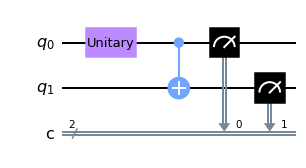

In [22]:
# Orthonormalize the weights
U = gs_2d_real(model_weights)

# Initialize Quantum Circuit
circ1 = QuantumCircuit(2, 2)

# Apply weights matrix as unitary gate
circ1.unitary(U, 0)

# Apply CX
circ1.cx(0, 1)

# Measure
circ1.measure([0, 1], [0, 1])

# Draw Circuit
circ1.draw('mpl')

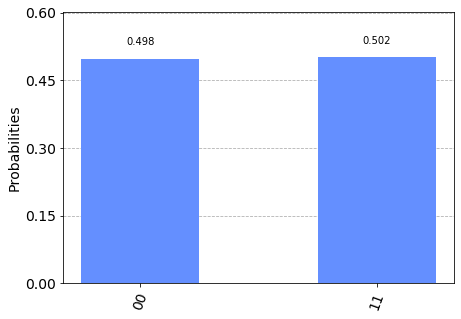

In [23]:
simulator = Aer.get_backend('qasm_simulator')

# For Mathematical Representation
results = execute(circ1, simulator).result()

# Count Results
counts = results.get_counts(circ1)

# Plot Histogram
plot_histogram(counts)

#### 2. Solving for $\phi$ and $\theta$

###### Performing 3rd Quadrant Inverse

However, the problem requires that the circuit being built using only $R_x$ and $R_y$ gates. This means that we have to convert the matrix back to its angular form

$$W = \begin{bmatrix} \alpha & \beta \\ \gamma & \delta \end{bmatrix} = \begin{bmatrix} \cos\frac{\phi + \theta}{2} & \sin\frac{\phi - \theta}{2} \\ \sin\frac{\phi + \theta}{2} & \cos\frac{\phi - \theta}{2}\end{bmatrix}$$

Equate one element from one matrix to another and taking the trigonometric inverse, we are left with four sets of equations

$$\frac{\phi + \theta}{2} = \cos^{-1}\alpha$$

$$\frac{\phi + \theta}{2} = \sin^{-1}\gamma$$

$$\frac{\phi - \theta}{2} = \sin^{-1}\beta$$

$$\frac{\phi - \theta}{2} = \cos^{-1}\delta$$

However, due to the cyclical nature of the sinusoidal functions, we also have to following

$$\frac{\phi + \theta}{2} = -\cos^{-1}\alpha$$

$$\frac{\phi + \theta}{2} = \pi-\sin^{-1}\gamma$$

$$\frac{\phi - \theta}{2} = \pi-\sin^{-1}\beta$$

$$\frac{\phi - \theta}{2} = -\cos^{-1}\delta$$

The system of equations might not look consistent because the $\cos^{-1}$ return output in the $1st$ and $2nd$ quadrant, whereas $\sin^{-1}$ return output in the $1st$ and $4th$ quadrant. 
f
In the unit circle, the $\sin$ & $\cos$ function is the same only in the $1st$ and $3rd$ quadrant. This means that 

$$\cos^{-1}(x) \ \& \ \sin^{-1}(x), \ \forall \ x > 0 \ \longrightarrow \ 1st \text{ quadrant}$$

$$\cos^{-1}(x) \ \& \ \sin^{-1}(x), \ \forall \ x < 0 \ \longrightarrow \ 3rd \text{ quadrant}$$

We can create the following piece-wise function

$$\cos^{-1}_\text{q3}(x) = \begin{cases} \cos^{-1} (x) \ \text{if } x \geq 0 \\ 2 \pi -\cos^{-1} (x) \ \text{if } x < 0\end{cases}$$

$$\sin^{-1}_\text{q3}(x) = \begin{cases} \sin^{-1} (x) \ \text{if } x \geq 0 \\ \pi -\sin^{-1} (x) \ \text{if } x < 0\end{cases}$$

The '$q3$' here just emphasizes the fact that the inverse function returns $\theta$ value in the $3rd$ quadrant

###### Inverse Cosine

In [24]:
acos_q3 = lambda x: np.arccos(x) if x >= 0 else 2*np.pi - np.arccos(x)

###### Inverse Sine

In [25]:
asin_q3 = lambda x: np.arcsin(x) if x >= 0 else np.pi - np.arcsin(x)

###### Full Inverse

In [26]:
def inverse_q3(M):
    
    """
    Return a matrix with the appropriate 3rd quadrant inverse of each element
    
    Parameters:
    -----------
    M: ndarray
        Orthonormal matrix
        
    Returns:
    --------
    M_inverse: ndarray
        Matrix with the appropriate 3rd quadrant inverse
    
    """
    
    # Extract the components
    alpha = M[0, 0]
    beta = M[0, 1]
    gamma = M[1, 0]
    delta = M[1, 1]

    # Perform inverse trigs on each components
    alpha = acos_q3(alpha)
    beta = asin_q3(beta)
    gamma = asin_q3(gamma)
    delta = acos_q3(delta)
    
    # Check for uniqueness
    assert (np.round(alpha - gamma, 10) == 0) ^ (np.round(beta - delta, 10) == 0), 'Not unique'
    
    M_inverse = np.array([[alpha, beta], [gamma, delta]])
    
    return M_inverse

In [27]:
M_inverse = inverse_q3(H)

###### Creating a consistent system of equations

From above, we can see that the odd one out element $M_\text{trig}$ is the element with different sign as the others in $M_\text{orthogonal}$

Take the examples from $M_\text{trig}$ above, in a general form, we have

$$M_\text{ trig} = \begin{bmatrix} \alpha & \alpha \\ \alpha & w \end{bmatrix}$$

$$\frac{\phi + \theta}{2} = \begin{Bmatrix}  \alpha \\ \alpha \end{Bmatrix} \rightarrow \text{ consistent}$$

$$\frac{\phi - \theta}{2} = \begin{Bmatrix}  \alpha \\ w \end{Bmatrix} \rightarrow \text{ inconsistent!?}$$

Let's assume that both sets of equation have the same value.

$$\frac{\phi + \theta}{2} = \frac{\phi - \theta}{2} = \alpha \tag{Assumption}$$

Solving this, the results are

$$\phi = 2\alpha$$

$$\theta = 0$$

Plugging the value back into the original rotation matrix, we have

$$\begin{pmatrix}\phi = 2\alpha \\ \theta = 0 \end{pmatrix} \longrightarrow \begin{bmatrix} \cos\frac{\phi + \theta}{2} & \sin\frac{\phi - \theta}{2} \\ \sin\frac{\phi + \theta}{2} & \cos\frac{\phi - \theta}{2}\end{bmatrix} = \underbrace{\begin{bmatrix} \cos\phi & \sin\phi \\ \sin\phi & \cos\phi\end{bmatrix}}_{\text{not unitary } \forall \ \phi }$$

It is clear the the above matrix is not unitary for all values of $\phi$, and therefore the assumption yields a contradiction. 

This means that each set of equation have a different value. We can do this by searching for the odd-one-out

###### Odd-One-Out Grid Search

**Problem**: Given an $n \times n$ grid with elements, we want to identify $w$ such that $w$ is unique and all other elements are identical.

Here because we know that $n\geq 2$, we can use the comparison and search method, which has $O(n^2)$ complexity using linear search.

The quantum analog of this method uses Grover's search and has $O(\sqrt{n})$.

Compare the first two element in the grid called $a$ and $b$ respectively. 

- If $a = b$, search for $w \neq a$ using linear search or Grover's search

- Else if $a \neq b$, compare the $a$ with a third element, $c$

    - If $a = c$, we have found $w = b$ in $O(1)$
    
    - Else if $a \neq c$, we also have found $w = a$ in $O(1)$

There are $O(1)$ comparison steps, and $O(n^2)$ or $O(\sqrt{n})$ search steps depending on the algorithm, which makes the overall complexity $O(n^2)$ or $O(\sqrt{n})$ respectively.

In [28]:
def odd_search(M):
    
    """
    Return the constant vector used for solving systems of equations
    
    Parameters:
    -----------
    M: ndarray
        (n, n) matrix of possible constants of the system of equations
        
    Returns:
    --------
    constant_vec: ndarray
        (n, 1) constant vector 
        
    """

    n = M.shape[0]

    a = M[0, 0] # First element
    b = M[1, 0] # Second element
    c = M[0, 1] # Third element

    if np.round(a - b, 10) == 0:

        # Find the index of the element satisfying the conditions
        coor = tuple(np.squeeze(np.where(M != a)))

        # Build the vector
        constant_vec = np.full(shape = (n, 1), fill_value = a)
        constant_vec[coor[1], 0] = M[coor]

    # Comparing with a third element
    elif np.round(a - c, 10) == 0:

        # Build the vector
        constant_vec = np.full(shape = (n, 1), fill_value = a)
        constant_vec[0] = b

    else:

        # Build the vector
        constant_vec = np.full(shape = (n, 1), fill_value = c)
        constant_vec[0] = a

    return constant_vec

In [29]:
odd_search(H)

array([[ 0.70710678],
       [-0.70710678]])

Now that we were able to have two set of equations with distince solutions in a vector

$$\frac{\phi + \theta}{2} = \alpha$$

$$\frac{\phi - \theta}{2} = w$$

Expand the rest of the variables into matrix form

$$\underbrace{\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}}_{M} \ \underbrace{\begin{bmatrix} \phi \\ \theta \end{bmatrix}}_{X} = 2 \underbrace{\begin{bmatrix} \alpha \\ w \end{bmatrix}}_{A}$$

Solving for $\phi, \theta$ by taking the inverse of $M$ yields

$$\underbrace{\begin{bmatrix} \phi \\ \theta \end{bmatrix}}_{X} = \underbrace{ \frac{1}{2} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} }_{M^{-1}} 2 \underbrace{\begin{bmatrix} \alpha \\ w \end{bmatrix}}_{A}$$

Which reduces down to 

$$\underbrace{\begin{bmatrix} \phi \\ \theta \end{bmatrix}}_{X} = \underbrace{ \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} }_{M} \underbrace{\begin{bmatrix} \alpha \\ w \end{bmatrix}}_{A} = \begin{bmatrix} \alpha + w \\ \alpha - w \end{bmatrix}$$

In [30]:
def solve_sys(constant_vec):
    
    """
    Solve for phi, theta
    
    Parameters:
    -----------
    constant_vec: ndarray
        Vector of constants in the correct order
        
    Returns:
    --------
    solution: ndarray
        Vector of solutions correspond to phi, theta
        
    """
    
    variable_matrix = np.array([[1, 1], [1, -1]])
    
    solution = np.dot(variable_matrix, constant_vec).reshape(2, 1)
    
    return solution

After all this, we need the solution when plugged into $R_y$ and $R_x$ to be approximately equal to the original unitary matrix.

In [31]:
for i in range(10_000):

    # Initialize random matrix
    M_random = np.random.uniform(low = -1, high = 1, size = (2, 2))

    # Orthonormalize it
    M_ortho = gs_2d_real(M_random)

    # Inverse Trig the components
    M_inverse = inverse_q3(M_ortho)

    # Get constant vector
    constant_vec = odd_search(M_inverse)

    # Solve for phi, theta
    phi, theta = solve_sys(constant_vec)

    # Rewrite Rx and Ry gate
    Rx = lambda theta: np.array([[np.cos(theta/2), np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
    Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])

    # Reapply back into rotational matrix
    M_reconstruct = np.dot(Ry(phi).reshape(2, 2), Rx(theta).reshape(2, 2))

    # The absolute value is used here because there can be different sign representation of orthonormal basis
    # However, this does not affect the final probability
    aae(np.abs(M_ortho), np.abs(M_reconstruct), decimal = 10)

In [32]:
view(M_ortho)

view(M_reconstruct)

Matrix([
[-0.984754131848131,  0.173952004323128],
[-0.173952004323128, -0.984754131848131]])

Matrix([
[-0.984754131848131,  0.173952004323128],
[-0.173952004323128, -0.984754131848131]])

Put everything together, we can create an end-to-end circuit that takes the weights from gradient descent and implement the correct angle values for its rotation gate

#### Full Implementation from Weights Matrix

In [86]:
def circ_from_weights(W, circ = 'init', measure = True):
    
    """
    Create a circuit using only Rx, Ry and Cx gates
    
    Parameters:
    -----------
    W: ndarray
        Weight Matrix     
    circ: QuantumCircuit or 'yes':
        Allows initialization of brand new circuit or reuse old circuit
    measure: bool
        Add measurement gates to circuit
        
    Returns:
    --------
    circ: QuantumCircuit
        Full circuit with the correct value for phi and theta in the Ry and Rx gates
    
    """
    
    # Orthonormalize W
    M_ortho = gs_2d_real(W)

    # Inverse Trig the components
    M_inverse = inverse_q3(M_ortho)

    # Get constant vector
    constant_vec = odd_search(M_inverse)

    # Solve for phi, theta
    phi, theta = solve_sys(constant_vec)
    
    # Initialize circuit
    
    if circ == 'init':
        circ = QuantumCircuit(2, 2)

    # Apply Rx
    circ.rx(theta[0], 0)

    # Apply Ry
    circ.ry(phi[0], 0)

    # Apply CX
    circ.cx(0, 1)

    # Measure
    if measure:
        circ.measure([0, 1], [0, 1])

    # Draw Circuit
    circ.draw('mpl')
    
    return circ

Matrix([
[0.7071066891,  0.7071068733,            0,             0],
[           0,             0, 0.7071068733, -0.7071066891],
[           0,             0, 0.7071066891,  0.7071068733],
[0.7071068733, -0.7071066891,            0,             0]])

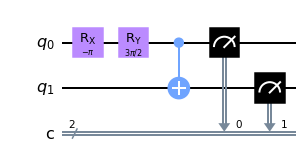

In [81]:
circ2 = circ_from_weights(model_weights)

circ2.draw('mpl')

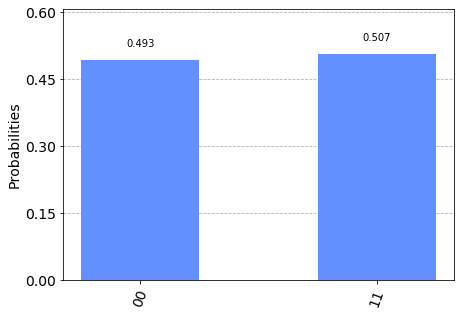

In [82]:
simulator = Aer.get_backend('qasm_simulator')

# For Mathematical Representation
results = execute(circ2, simulator).result()

# Count Results
counts = results.get_counts(circ2)

# Plot Histogram
plot_histogram(counts)

We can see that all three implementations of the Bell States circuit (Step 1, Step 14.1, Step 14.3) yield the same results. 

We have now finished the main part of the problem.

### Bonus Part

### Forward Propagation with Simulation

The classical analog of this is stochastic gradient descent, updating the weights for every example.

To test the practicality of this on a quantum machine, first test this classically to see the number of iterations requires for the matrix to approaches its optimal value. 

This can be done by editing the 'train' function from above. A new argument called 'stochastic' will be added that will allow the option of training after every example.

In [18]:
def train_stoch(X, y, init_weights = 'random', gd_method = 'batch', epoch = 50, 
          learning_rate = 0.1, print_frequency = 10, seed = 0, print_weights = True):
    
    """
    Train model from (X, y) pairs
    
    Parameters
    ----------
    X: ndarray
        X-values for training
    y: ndarray
        y-values for the corresponding X-values
    init_weights: str
        'random' or 'zeros'
    gd_method: str
        'batch' or 'stochastic' (weights update after every trainign examples)
    epoch: int
        Number of weights updates through forward / backpropagation over entire dataset
    learning_rate: float
        Step size for weights update
    print_frequency: int
        Loss / mse print frequency
    seed: int
        Used for pseudo-randomly generate matrix
    print_weights: bool
        Show weights at the end for visual comparison
    
    Returns
    -------
    W: ndarray
        Final weights after training
    
    """
    
    # Weights initialization
    if type(init_weights) == str:
        W = initialize(init_type = init_weights, seed = seed)
    else:
        W = init_weights

    print('Training: \n')
    
    if gd_method == 'stochastic':
        
        # Stochastic
        
        for n in range(epoch):
            
            # Iterate over training examples
            for i in range(X.shape[1]):

                # Reshape the individual training examples
                X_stoch = X[:, i].reshape(2, 1) 
                y_stoch = y[:, i].reshape(2, 1)

                # Foward Propagation
                y_hat = forward_prop(W, X_stoch)

                # Compute cost
                L = cost(y_stoch, y_hat)

                # Compute mse
                mse = cost(W, M_correct)

                # Backpropagation
                grad = back_prop(y_stoch, y_hat, X_stoch) * -2 # Multiply by a factor of -2 from above

                # Gradient Descent (The bigger the learning rate, the faster the model trains <= 1)
                W = gradient_descent(W, grad, learning_rate = learning_rate) 
                
            # Print loss and mse
            if n % print_frequency == 0:
                print(f'{n}th epoch, loss = {np.round(L, 6)}, mse = {np.round(mse, 6)}')
                    
    
    else:
        
        # Batch GD
        
        for n in range(epoch):

            # Foward Propagation
            y_hat = forward_prop(W, X)

            # Compute cost
            L = cost(y, y_hat)

            # Compute mse
            mse = cost(W, M_correct)

            # Print loss and mse
            if n % print_frequency == 0:
                print(f'{n}th epoch, loss = {np.round(L, 6)}, mse = {np.round(mse, 6)}')

            # Backpropagation
            grad = back_prop(y, y_hat, X) * -2 # Multiply by a factor of -2 from above

            # Gradient Descent (The bigger the learning rate, the faster the model trains <= 1)
            W = gradient_descent(W, grad, learning_rate = learning_rate) 
        
        
    # Normalized W matrix
    
    W /= np.linalg.norm(W, axis = 0)
        
    # Print weights
    if print_weights:
        print('\n')
        print('Final Weights')
        view(W)
        print(f'MSE: {mse}')
        print('\n')
        
    return W

Test whether stochastic GD or batch GD is better accuracy-wise (optimizing) and time-wise (satisfiscing).

In [861]:
# Define correct matrix
M_correct = H

print('Correct Matrix:')
view(M_correct)
print('\n')

# Create data
X_train, y_train, X_test, y_test = create_data(M_correct, size = 7, train_split = 1)

# Train model

model_1 = train_stoch(X_train, y_train, init_weights = 'random', gd_method = 'stochastic', epoch = 20, learning_rate = 0.77, print_frequency=1, seed = 1)

# model_2 = train_stoch(X_train, y_train, init_weights = 'random', gd_method = 'batch', epoch = 35, learning_rate = 1, print_frequency=2)

Correct Matrix:


Matrix([
[0.707106781186547,  0.707106781186547],
[0.707106781186547, -0.707106781186547]])



Training: 

0th epoch, loss = 0.070167, mse = 0.241287
1th epoch, loss = 0.028641, mse = 0.113486
2th epoch, loss = 0.013961, mse = 0.055091
3th epoch, loss = 0.006771, mse = 0.026721
4th epoch, loss = 0.003284, mse = 0.012961
5th epoch, loss = 0.001593, mse = 0.006287
6th epoch, loss = 0.000773, mse = 0.003049
7th epoch, loss = 0.000375, mse = 0.001479
8th epoch, loss = 0.000182, mse = 0.000717
9th epoch, loss = 8.8e-05, mse = 0.000348
10th epoch, loss = 4.3e-05, mse = 0.000169
11th epoch, loss = 2.1e-05, mse = 8.2e-05
12th epoch, loss = 1e-05, mse = 4e-05
13th epoch, loss = 5e-06, mse = 1.9e-05
14th epoch, loss = 2e-06, mse = 9e-06
15th epoch, loss = 1e-06, mse = 5e-06
16th epoch, loss = 1e-06, mse = 2e-06
17th epoch, loss = 0.0, mse = 1e-06
18th epoch, loss = 0.0, mse = 1e-06
19th epoch, loss = 0.0, mse = 0.0


Final Weights


Matrix([
[0.707471451437452,  0.707239710826266],
[0.706741922770247, -0.706973826552567]])

MSE: 2.5081054786844433e-07




In [81]:
y_train

array([[ 0.99144824],
       [-0.13050054]])

For 9 training examples, the stochastic gradient descent performs well with 5 epochs. Batch gradient descent offers comparable accuracy with 40 epochs. However, if time is a constraint. Stochastic gradient descent far outperforms batch gradient descent in more than half the time.

Now that we understand the gradient descent method of the simulation. The steps to implement forward propagation with simulation is similar to the classical method with a few tweaks to adapt to the machinery used

Here's the basic outline of the things involved:

1. Initialize a random weight matrix by randomize the $\theta$ & $\phi$ arguments

2. Initialize the starting qubits to some separable states using the $R_X$ & $R_Y$ gate at the disposal

3. Run the states over the circuit

4. Measure the results, get the count distribution and infer back the amplitudes. 

This is done by square rooting the probability number. 

This means that the amplitude can only have positive arguments. 

Therefore, we have to choose the appropriate starting values that has positive output amplitudes.

###### 1. Initialize a random weight matrix by randomize the $\theta$ & $\phi$ arguments

We already satisfy this with the 'circ_from_weights' function from above

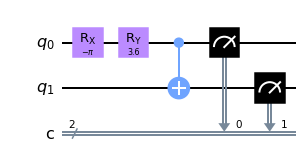

In [88]:
# Initialize random phi and theta
W = np.random.rand(2, 2)

circ = circ_from_weights(W)

circ.draw('mpl')

###### 2. Initialize the starting qubits to some separable states using the $R_X$ & $R_Y$ gate at the disposal

###### 3. Run the states over the circuit

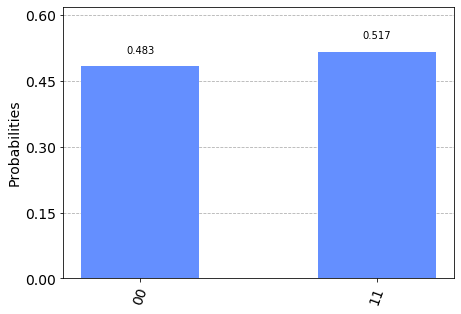

In [89]:
simulator = Aer.get_backend('qasm_simulator')

# For Mathematical Representation
results = execute(circ2, simulator).result()

# Count Results
counts = results.get_counts(circ2)

# Plot Histogram
plot_histogram(counts)

From this histogram, we should be able to infer the resulting statevector. In this case it's

$$|\psi \rangle = \sqrt{P(\psi \searrow 00)} \ |00\rangle + \sqrt{P(\psi \searrow 11)} \ |11\rangle$$

In general, this can be expressed as 

$$|\psi \rangle = \sum_{i}^{N} \sqrt{P (\psi \searrow s_i)} \ |s_i\rangle, \text{where } s_i \text{ are the basis states}$$

In [3]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)